### Summary: 

Read in returns data, risk free rate and inflation rate<br>

Create 3 portfolios, 1 of stocks, 60/40 (stocks/bonds) and 60/40/40 (stocks/bonds/managed futures)

look at the impact of different spending policies across different measures:<br>
    measure amount paid out <br>
    consistancy of payments <br>
    final wealth of portfolio<br>


### To Do In Future in order of importance:

Currently using stock and bond returns for US. In next iteration expand analysis by randomly pulling returns from different countries on each year since US stock returns are abnormally high.

look at dispersion of outcomes when rebalancing in different months (offset logic already written)

FRED Inflation statistics are revised. in next iteration use ALFRED point in time correct estimates to see how much this impacts analysis. Is suspect effect is small

### Reading: 

Princeton spending rule: http://pr.princeton.edu/news/01/q1/0127-endowspend.htm#:~:text=While%20Princeton's%20policy%20does%20not,endowment%20was%20desirable%20and%20appropriate.

Harvard spending rule: https://www.harvardmagazine.com/2016/10/how-harvard-sets-endowment-distribution <br>

Yale spending rule: https://your.yale.edu/policies-procedures/policies/2202-endowment-spending-and-distributions#:~:text=The%20spending%20amount%20determined%20by,start%20of%20the%20prior%20year.


#article on trend followin
https://www.aima.org/article/trend-following-what-s-not-to-like.html

#managed futres explainer
#http://advisor.morningstar.com/uploaded/pdf/Alt_Managed-Category.pdf

In [1]:
fred_api_key = '3c93f8c94cd55ed22584015fb3d29aff'

In [11]:
from educational_resources.Datasets.data_preprocessing import shiller_data, BTOP50_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fredapi import Fred
fred = Fred(api_key=fred_api_key)

inflation='CPIAUCSL'
risk_free_rate = 'FEDFUNDS'

inflation_series = fred.get_series(inflation).pct_change()
#inflation_series_first_release = fred.get_series_first_release(inflation)

risk_free_rate_series = fred.get_series(risk_free_rate)/(12*100)
#risk_free_rate_series_first_release = fred.get_series_first_release(risk_free_rate)

FRED_data = pd.concat([inflation_series,risk_free_rate_series],axis=1).rename(columns={0:'inflation_index',1:'risk_free_rate'})

stock_series = fred.get_series('SP500')
temp = stock_series.resample('m').first().reset_index()
temp['index'] = pd.to_datetime(temp['index'].astype('str').str[:-3], format='%Y-%m')
stock_series = temp.set_index('index')[0]
stock_series = stock_series.pct_change()

#data is inflation adjusted. I correct for this later on
stocknbonddata = shiller_data()
stocknbonddata.columns = ['Stock','Long Bonds']
stocknbonddata['Stock'] = stocknbonddata['Stock'].str.replace(',', '').astype(float)

MonRtns = stocknbonddata.pct_change().dropna().reset_index()

CTA = BTOP50_data()

returns = CTA.merge(MonRtns, on='Date')[1:]
returns['CTA'] = returns['CTA'].astype(float)
returns = returns.set_index('Date')

all_data = pd.concat([returns,FRED_data],axis=1)

#uninflation adjust bonds and stocks index 
all_data['Stock'] = all_data['Stock'] + all_data['inflation_index']
all_data['Long Bonds'] = all_data['Long Bonds'] + all_data['inflation_index']

all_data['60/40'] = .6 * all_data['Stock'] + .4 * all_data['Long Bonds']
all_data['60/40/40'] = (.6 * all_data['Stock'] + .4 * all_data['Long Bonds'] + 
                        .4 * all_data['CTA'] - (.4 * all_data['risk_free_rate']+.005/12)) #60/40/40 - 40 (risk free + 50 bp annually)


overlapping_period_data = all_data.dropna().copy(deep=True)

/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19537/1293067005.py:21: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  temp = stock_series.resample('m').first().reset_index()


In [3]:
def plot_cumrtn(data):
    ((data+1).cumprod()-1).plot()
    
portfolios =['Stock','60/40','60/40/40'] 
#plot_cumrtn(overlapping_period_data[portfolios])


def apply_rule(rule, prior_year_nominal_payout, previous_year_starting_balance, current_balance, trailing_1_yr_adj):
    if current_balance == 0:
        return 0 
    if rule == 'yale_rule':
        to_spend = yale_rule(prior_year_nominal_payout, 
                              previous_year_starting_balance, 
                              trailing_1_yr_adj)
    
    elif rule == 'four_pct_infl_adj':
        to_spend = four_percent_rule(prior_year_nominal_payout, trailing_1_yr_adj)
    
    if to_spend <= current_balance:
        return to_spend
    else:
        return current_balance
    
def four_percent_rule(prior_year_nominal_payout, trailing_1_yr_adj):
    '''
    trailing 1 year adjustment is the adjustment due to inflation and taxes
    '''
    return prior_year_nominal_payout * (1+trailing_1_yr_adj)

def yale_rule(prior_year_nominal_payout, previous_year_starting_balance, trailing_1_yr_adj, smoothing = .2):
    '''
    5.25% is yales target long term payout yale has fixed constraints so the payout is not 
    more than 6.5% of the market value and not less than 4% after adjusting for inflation and taxes
    
    trailing 1 year adjustment is the adjustment due to inflation and taxes
    '''
    combined_rate = smoothing * .0525 * previous_year_starting_balance + (1-smoothing) * prior_year_nominal_payout
    minimum = .04*previous_year_starting_balance
    maximum = .065*previous_year_starting_balance
    return min(max(minimum, combined_rate*(1+trailing_1_yr_adj)), maximum)

# def harvard_rule(prior_year_nominal_payout, previous_year_starting_balance, trailing_1_yr_adj, smoothing=.3):
#     previous_spending = prior_year_nominal_payout * trailing_1_yr_adj * (1-smoothing)
#     smoothing_comp = (previous_year_starting_balance - prior_year_nominal_payout)* 1.072 * .0525 * smoothing
#     combined = previous_spending + smoothing_comp
#     return combined

In [ ]:
spending_calc_data = overlapping_period_data.copy(deep=True).drop(columns=['CTA','Long Bonds','risk_free_rate'])

annualized_returns = {}

#spending_calc_data
relevant_cols = ['Stock','inflation_index','60/40','60/40/40']

#calc annualizd returns using starting on different months, needed when we come back to look at the impact of rebalance timing luck
for i in np.arange(12):
    temp_data = spending_calc_data[relevant_cols].copy(deep=True)
    temp_data.index = temp_data.index+pd.DateOffset(months=i)
    annualized_returns['offset'+str(i)] = temp_data.resample('A').apply(lambda x: ((x + 1).cumprod()-1).last("D"))

/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19537/1635298418.py:12: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annualized_returns['offset'+str(i)] = temp_data.resample('A').apply(lambda x: ((x + 1).cumprod()-1).last("D"))
/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19537/1635298418.py:12: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  annualized_returns['offset'+str(i)] = temp_data.resample('A').apply(lambda x: ((x + 1).cumprod()-1).last("D"))
/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19537/1635298418.py:12: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annualized_returns['offset'+str(i)] = temp_data.resample('A').apply(lambda x: ((x + 1).cumprod()-1).last("D"))
/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19537/1635298418.py:12: Fut

In [ ]:
analytics = {}

rules = ['four_pct_infl_adj','yale_rule'] #'harvard_rule'
portfolios = ['Stock','60/40','60/40/40']

starting_value = 10**6
starting_spend = {'four_pct_infl_adj':starting_value * .04,
                  'yale_rule':starting_value * .0525}
                  #'harvard_rule': starting_value * 

#create a dictionary to store the analytics
for rule in rules:
    analytics[rule] = {}
    for portfolio in portfolios:
        analytics[rule][portfolio] = {}
        for data in ['market_value','spending']:
            analytics[rule][portfolio][data] = []


#simulation assumes we start with a lump sum of money and immediately withdraw 
#from it at the start of the simulation and each year afterword at the start of the year

#using offset0 annualized returns to start
market_data = annualized_returns['offset0']
for index, row in market_data.iterrows():
    if index < market_data.index[1]:
        for rule in rules: 
            for portfolio in portfolios: 
                #starting account value
                analytics[rule][portfolio]['market_value'].append(starting_value)
                
                #first year spend
                analytics[rule][portfolio]['spending'].append(starting_spend[rule])
                
                #update account value based on dollar invested and investment returns
                invested_dollars = starting_value - starting_spend[rule]
                market_value_end_of_year = invested_dollars * (row[portfolio]+1)
                analytics[rule][portfolio]['market_value'].append(market_value_end_of_year)
                    
    if index >= market_data.index[1]:
        for rule in rules: 
            for portfolio in portfolios: 
                prev_year_spending = analytics[rule][portfolio]['spending'][-1]
                prev_start_of_year_mv = analytics[rule][portfolio]['market_value'][-2]
                current_mv = analytics[rule][portfolio]['market_value'][-1]
                spending = apply_rule(rule, 
                                      prev_year_spending,
                                      prev_start_of_year_mv,
                                      current_mv,
                                      row['inflation_index'])
                
                analytics[rule][portfolio]['spending'].append(spending)
                
                invested_dollars = current_mv - analytics[rule][portfolio]['spending'][-1]
                market_value_end_of_year = invested_dollars * (row[portfolio]+1)
                analytics[rule][portfolio]['market_value'].append(market_value_end_of_year)
    
#convert the data to a pandas dataframe  
for rule in rules:
    for portfolio in portfolios:
        for data in ['market_value','spending']:
            analytics[rule][portfolio][data] = pd.Series(analytics[rule][portfolio][data])
        analytics[rule][portfolio] = pd.DataFrame.from_dict(analytics[rule][portfolio], orient='index').T

sim_rule_stats = {}
for rule in rules:
    sim_rule_stats[rule] = pd.concat(analytics[rule],axis=1)
sim_rule_stats = pd.concat(sim_rule_stats, axis=1)

#add date index to the analytics data
index = pd.concat([pd.DataFrame({'Stock':[0],'inlation_index':[0],'60/40':[0],'60/40/40':[0]}, index=[market_data.index[0] - pd.DateOffset(years=1)]), market_data])['Stock']
sim_rule_stats['index'] = index.reset_index()['index']
sim_rule_stats.set_index('index',inplace=True)

In [90]:
market_data.head(1)

,Stock,inflation_index,60/40,60/40/40
1987-12-31,0.128696,0.037702,0.059748,0.193632


In [91]:
sim_rule_stats.head(1)

four_pct_infl_adj                                              \
                       Stock                 60/40              60/40/40   
                market_value spending market_value spending market_value   
index                                                                      
1986-12-31         1000000.0  40000.0    1000000.0  40000.0    1000000.0   

                       yale_rule                                              \
                           Stock                 60/40              60/40/40   
           spending market_value spending market_value spending market_value   
index                                                                          
1986-12-31  40000.0    1000000.0  52500.0    1000000.0  52500.0    1000000.0   

                     
                     
           spending  
index                
1986-12-31  52500.0

Text(0.5, 1.0, 'non inflation adjusted spending from yale rule and 4% rule on different portfolios')

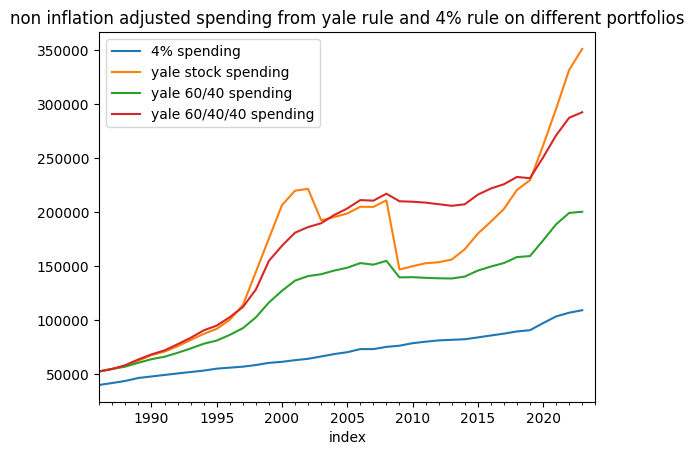

In [73]:
pd.concat([sim_rule_stats['four_pct_infl_adj']['Stock']['spending'].rename('4% spending'),
           sim_rule_stats['yale_rule']['Stock']['spending'].rename('yale stock spending'),
           sim_rule_stats['yale_rule']['60/40']['spending'].rename('yale 60/40 spending'),
           sim_rule_stats['yale_rule']['60/40/40']['spending'].rename('yale 60/40/40 spending')
           ], axis=1).plot()
plt.title("non inflation adjusted spending from yale rule and 4% rule on different portfolios")

(100000.0, 10000000.0)

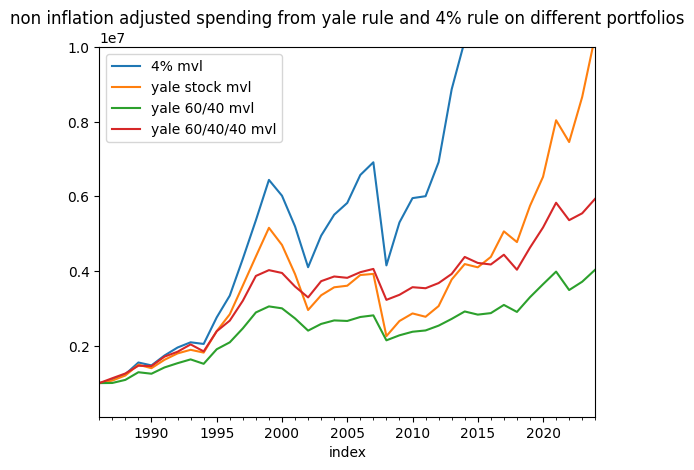

In [75]:
pd.concat([sim_rule_stats['four_pct_infl_adj']['Stock']['market_value'].rename('4% mvl'),
           sim_rule_stats['yale_rule']['Stock']['market_value'].rename('yale stock mvl'),
           sim_rule_stats['yale_rule']['60/40']['market_value'].rename('yale 60/40 mvl'),
           sim_rule_stats['yale_rule']['60/40/40']['market_value'].rename('yale 60/40/40 mvl')
           ], axis=1).plot()
plt.title("non inflation adjusted spending from yale rule and 4% rule on different portfolios")
plt.ylim(10**5,10**7)
#plt.show()

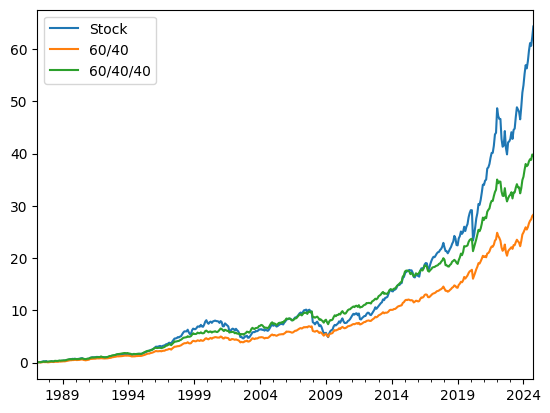

In [58]:
plot_cumrtn(overlapping_period_data[portfolios])

In [89]:
portfolio_inflation_adj_returns = market_data.subtract(market_data['inflation_index'],axis=0).drop('inflation_index',axis=1)

pd.concat([portfolio_inflation_adj_returns.mean().rename("mean return"),
           portfolio_inflation_adj_returns.std().rename("volatility"),
           (portfolio_inflation_adj_returns.mean()/portfolio_inflation_adj_returns.std()).rename("sharpe ratio")],axis=1)

,mean return,volatility,sharpe ratio
Stock,0.100830,0.156482,0.644355
60/40,0.069774,0.100980,0.690966
60/40/40,0.079455,0.104698,0.758898


In [ ]:
observations: 
1) in this analysis the yale rule provides alot more spending power to the investor and provides an unambiguous rule of how to increase/decrease spending.

2) the 60/40/40 portfolio dominates the 60/40 portfolio because they have similar volatility but the 60/40/40 portfolio has a higher return. 

In [ ]:
#some capital market assumptions if useful in the future

# long term return asusmptions
# 8% market returns
# 5% bond and CTA returns
# 4.5% risk free
# 3% inflation returns

# print('portfolio return assumptions', round(.6*.08+.4*.05+.4*.05-.4*.04,3))
# print('inflation assumption', .03)

# FRED_data.loc[:'1986-01-01'].resample("A").apply(lambda x: ((x + 1).cumprod()-1).last("D")).mean()